# Линейные модели. Задачи регрессии и классификации.

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor, SGDClassifier, Ridge, Lasso

## Линейная регрессия

### Подготовка данных

In [ ]:
df = pd.read_excel('Concrete_Data.xls', sheet_name='Sheet1')

In [ ]:
df.head()

In [ ]:
df.describe().T

In [ ]:
df = df.rename(lambda x: x.split('(')[0].strip().replace(' ', '_').lower(), axis=1)

In [ ]:
df.duplicated().sum()

In [ ]:
df = df.drop_duplicates()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='icefire');

In [ ]:
sns.pairplot(df, y_vars='concrete_compressive_strength');

In [ ]:
df.head()

### Подготовка выборок

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['concrete_compressive_strength'], axis=1),
                                                    df['concrete_compressive_strength'],
                                                    test_size=0.2,
                                                    random_state=177013,
                                                    shuffle=True,
                                                    )

In [ ]:
X_train_b = X_train.copy()
X_train_b['bias'] = 1

X_test_b = X_test.copy()
X_test_b['bias'] = 1

In [ ]:
weights = np.linalg.inv(X_train_b.T @ X_train_b) @ X_train_b.T @ y_train

In [ ]:
weights.rename(lambda x: df.columns[x] if x != len(weights) - 1 else 'bias')

In [ ]:
y_pred = X_test_b @ weights.values

In [ ]:
y_pred

## Метрики регрессии

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Среднеквадратичная ошибка (MSE)

In [ ]:
((y_test - y_pred)**2).mean()

In [ ]:
((y_test - y_train.mean())**2).mean()

In [ ]:
mean_squared_error(y_test, y_pred)

### Средняя абсолютная ошибка (MAE)

In [ ]:
(abs(y_test - y_pred)).mean()

In [ ]:
mean_absolute_error(y_test, y_pred)

### Коэффициент детерминации ($R^2$)

In [ ]:
1 - mean_squared_error(y_test, y_pred) / y_test.var(ddof=0)

In [ ]:
r2_score(y_test, y_pred)

In [ ]:
def show_regression_metrics(y_true, y_pred):
    print(f'MSE: {mean_squared_error(y_true, y_pred)}')
    print(f'MAE: {mean_absolute_error(y_true, y_pred)}')
    print(f'R2: {r2_score(y_true, y_pred)}')

## Линейная регрессия в sklearn

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X_train, y_train)

In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
show_regression_metrics(y_test, y_pred)

## Градиентный спуск

In [ ]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit(X_train)

In [ ]:
X_train_b = scaler.transform(X_train)
X_train_b = np.hstack([X_train_b, np.ones((len(X_train), 1))])

In [ ]:
X_test_b = scaler.transform(X_test)
X_test_b = np.hstack([X_test_b, np.ones((len(X_test), 1))])

In [ ]:
weights = np.linalg.inv(X_train_b.T @ X_train_b) @ X_train_b.T @ y_train

In [ ]:
pd.Series(weights, index=[df.columns[x] for x in range(len(weights) - 1)] + ['bias'])

$$
\frac{\partial MSE}{\partial w} = \frac{\partial MSE}{\partial y_{pred}} \frac{\partial y_{pred}}{\partial w}
$$

$$
\frac{\partial MSE}{\partial y_{pred}} = \frac{\partial(y-y_{pred})^2}{\partial y_{pred}} = \frac{\partial(y^2-2y\cdot y_{pred}+y_{pred}^2)}{\partial y_{pred}} = 2(y_{pred} - y)
$$

$$
\frac{\partial y_{pred}}{\partial w} = \frac{(\partial X \cdot w)}{\partial w} = X
$$

In [ ]:
num_iterations = 100
learning_rate = 1e-4
msetrain = []
msetest = []
checkpoints = []

improved_weights = np.zeros(len(X_train.columns) + 1)

for _ in range(num_iterations):
    preds = X_train_b @ improved_weights
    
    # d(MSE) / d(preds)
    error = preds - y_train 
    msetrain.append(mean_squared_error(y_train, preds))
    msetest.append(mean_squared_error(y_test, X_test_b @ improved_weights))
    
    # d(MSE) / d(weights)
    gradient = X_train_b.T @ error
    
    improved_weights -= learning_rate * gradient
    checkpoints.append(improved_weights)

In [ ]:
weights

In [ ]:
improved_weights

In [ ]:
plt.plot(msetrain);
plt.plot(msetest);
plt.title('Функция потерь')
plt.xlabel('Итерация')
plt.ylabel('MSE');
plt.legend(['Обучающая выборка', 'Валидационная выборка']);

In [ ]:
y_pred = X_test_b @ improved_weights

In [ ]:
show_regression_metrics(y_test, y_pred)

In [ ]:
np.argmin(msetest)

In [ ]:
final_weights = checkpoints[np.argmin(msetest)]

In [ ]:
y_pred = X_test_b @ final_weights

In [ ]:
show_regression_metrics(y_test, y_pred)

### Градиентный спуск в sklearn

In [ ]:
sgd = SGDRegressor(random_state=177013, penalty=None)

In [ ]:
sgd.fit(X_train_b, y_train)

In [ ]:
y_pred = sgd.predict(X_test_b)

In [ ]:
show_regression_metrics(y_test, y_pred)

## Допущения линейной регрессии

- Линейность: подразумевается наличие линейной зависимости (но вы можете преобразовать признаки, чтобы ее обеспечить!).
- Слабая экзогенность: выборка не должна зывисеть от внешних факторов, погрешность измерений скажется на погрешности предсказаний.
- Отсутствие мультиколлинеарности: признаки не должны сильно коррелировать.
- Нормальность ошибки: ошибка предсказания должна распределяться нормально (и иметь матожидание около нуля):

In [ ]:
plt.hist(y_train - lr.predict(X_train), bins='fd');
plt.title('Распределение ошибок')
plt.xlabel('Ошибка предсказания')
plt.ylabel('Количество, шт');

- Гомоскедастичность: дисперсия ошибки должна быть постоянной:

In [ ]:
plt.scatter(y_train, (y_train - lr.predict(X_train)) ** 2);
plt.axhline(np.mean((y_train - lr.predict(X_train)) ** 2), color='red', linestyle='--')
plt.title('Распределение ошибок')
plt.xlabel('Истинное значение')
plt.ylabel('Ошибка$^2$');

- Независимость ошибок: проверяется с помощью DW-теста (значения статистики в норме от 1.5 до 2.5):

In [ ]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(y_train - lr.predict(X_train))

Большинство проблем можно решить одним махом, преобразовав входные данные с целью уменьшить их асимметрию. Обычное шкалирование почти не влияет на аналитическое решение, но необходимо для градиентного спуска. Однако есть методы, которые не только нормализуют данные, но и корректируют их форму:

- `PowerTransformer` - параметрический преобразователь, стабилизирующий дисперсию и уменьшающий скошенность методом максимального правдоподобия;
- `QuantileTransformer` - непараметрический преобразователь, превращающий распределение в равномерное или нормальное через PPF.

Платой за такое удобство является некоторое искажение линейных зависимостей.

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
for scaler in [
                StandardScaler(),
                QuantileTransformer(output_distribution='uniform', random_state=177013),
                QuantileTransformer(output_distribution='normal', random_state=177013),
                PowerTransformer(),
              ]:

    pipe = Pipeline([
                        ('scaler', scaler),
                        ('model', LinearRegression()),
                    ])
    
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f'Предобработка: {scaler}')
    show_regression_metrics(y_test, y_pred)
    print()

## Регуляризация

In [ ]:
for model in [
                Lasso(random_state=177013),
                Ridge(random_state=177013),
              ]:

    pipe = Pipeline([
                        ('scaler', PowerTransformer()),
                        ('model', model),
                    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f'Модель: {model}, веса: {model.coef_}')
    show_regression_metrics(y_test, y_pred)
    print()

# Логистическая регрессия

## Подготовка данных

In [294]:
df = pd.read_csv('titanic.csv')

In [295]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [296]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [297]:
df.duplicated().sum()

0

In [298]:
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)

In [299]:
df['Sex'] = (df['Sex'] == 'male').astype('int')

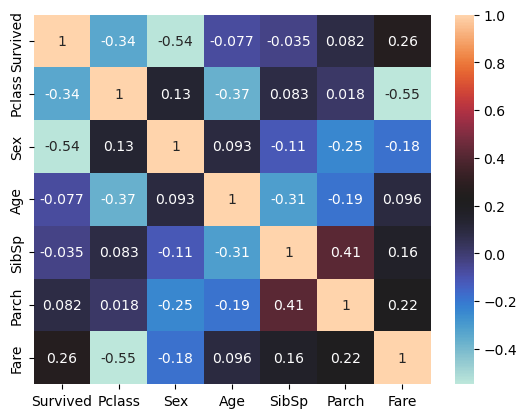

In [300]:
sns.heatmap(df.corr(), annot=True, cmap='icefire');

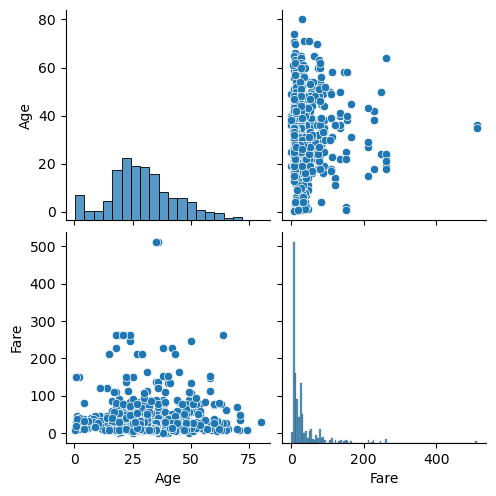

In [301]:
sns.pairplot(df[['Age', 'Fare']]);

In [302]:
df.groupby('Pclass')['Age'].agg(['count', 'mean', 'median'])

,count,mean,median
Pclass,,,
1,186,38.233441,37.0
2,173,29.877630,29.0
3,355,25.140620,24.0


In [303]:
df.groupby('SibSp')['Age'].agg(['count', 'mean', 'median', lambda x: x.isna().sum()])

,count,mean,median,<lambda_0>
SibSp,,,,
0,471,31.397558,29.0,137
1,183,30.089727,30.0,26
2,25,22.620000,23.0,3
3,12,13.916667,9.5,4
4,18,7.055556,6.5,0
5,5,10.200000,11.0,0
8,0,NaN,NaN,7


In [304]:
df['Age'] = df['Age'].fillna(df.groupby(['Pclass', 'SibSp'])['Age'].transform('median'))
df = df.dropna()

In [305]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500


## Разбиение на выборки

In [306]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Survived', axis=1),
                                                    df['Survived'],
                                                    test_size=0.2,
                                                    random_state=177013,
                                                    shuffle=True,
                                                    stratify=df['Survived'])

In [307]:
X_train_b = X_train.copy()
X_train_b['bias'] = 1

X_test_b = X_test.copy()
X_test_b['bias'] = 1

In [308]:
weights = np.linalg.inv(X_train_b.T @ X_train_b) @ X_train_b.T @ y_train

In [309]:
weights

0   -0.186331
1   -0.497133
2   -0.006066
3   -0.051657
4   -0.033305
5    0.000544
6    1.328394
dtype: float64

In [310]:
y_logits = X_test_b @ weights.values

In [311]:
y_logits.describe()

count    177.000000
mean       0.352304
std        0.290484
min       -0.151190
25%        0.118842
50%        0.270192
75%        0.585620
max        1.046547
dtype: float64

In [312]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [313]:
y_probs = y_logits.apply(sigmoid)

In [314]:
((y_probs > 0.5) == y_test).mean()

0.4124293785310734

In [315]:
1 - df['Survived'].mean()

0.6131221719457014

In [316]:
((y_probs > 0.62) == y_test).mean()

0.8192090395480226

In [317]:
from sklearn.metrics import accuracy_score

In [318]:
accuracy_score(y_test, (y_probs > 0.62))

0.8192090395480226

## Метрики классификации

In [335]:

from sklearn.metrics import (f1_score, roc_auc_score, average_precision_score, confusion_matrix, roc_curve,
                             precision_recall_curve, classification_report, recall_score, precision_score,
                             log_loss, brier_score_loss)

### Метрики для оценки моделей

Для оценки статистической верности моделей нужна метрика, которая будет:

- классонезависимой;
- порогонезависимой.

В качестве альтернативного варианта можно уравнять число представителей класса в обучающей выборке (oversampling, undersampling, параметр `class_weights` в sklearn), чтобы иметь возможность использовать интуитивные метрики с порогом 0.5. Такой подход имеет массу недостатков:

 - четкий баланс классов еще не гарантирует, что 0.5 будет оптимальным порогом;
 - на каждый эксперимент с пропорцией требуется переобучить модель;
 - модель более склонна "уезжать" в продакшене.
 
Поэтому **если от вас прямо не требуют обратного, оценивайте модели по "честным" метрикам, а "интуитивные" оставьте для презентации заказчику.**

#### Log loss (кросс-энтропия)

In [320]:
-(y_test * np.log(y_probs) + (1 - y_test) * np.log(1-y_probs)).mean()

0.6723890312259991

In [321]:
log_loss(y_test, y_probs)

0.6723890312259991

#### Показатель Брайера для бинарной классификации

In [322]:
mean_squared_error(y_test, y_probs)

0.24084915179818256

In [323]:
brier_score_loss(y_test, y_probs)

0.24084915179818256

### Метрики для презентации. Матрица ошибок.

In [324]:
def calculate_metrics(target_test, probabilities):
    cmatrix = confusion_matrix(target_test, probabilities > 0.5)

    ap = average_precision_score(target_test, probabilities)
    fpr, tpr, _ = roc_curve(target_test, probabilities)
    roc_auc = roc_auc_score(target_test, probabilities)

    precision, recall, thresholds = precision_recall_curve(target_test, probabilities)
    f_scores = 2 * recall * precision / (recall + precision)
    best_thresh = thresholds[np.argmax(f_scores)]
    best_f = np.max(f_scores)
    best_acc = accuracy_score(target_test, (probabilities > best_thresh))
    best_cmatrix = confusion_matrix(target_test, (probabilities > best_thresh))

    return best_f, roc_auc, best_acc, ap, best_thresh, fpr, tpr, recall, precision, cmatrix, best_cmatrix

In [325]:
def visualize(target_test, probabilities):
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    axes[0].plot([0, 1], linestyle='--')
    axes[1].plot([0.5, 0.5], linestyle='--')

    best_f, roc_auc, acc, ap, best_thresh, fpr, tpr, recall, precision, cmatrix, best_cmatrix = calculate_metrics(target_test, probabilities)
    print(f'ROC_AUC: {roc_auc:.2f}, AP (PR_AUC): {ap:.2f}, наилучший F1: {best_f:.2f} с порогом {best_thresh:.2f} (accuracy {acc:.2f})')
    axes[0].plot (fpr, tpr);
    axes[1].plot (recall, precision);

    axes[0].set (xlabel='FPR', ylabel='TPR', title='ROC-кривая', xlim=(0,1), ylim=(0,1))
    axes[1].set (xlabel='Recall', ylabel='Precision', title='PR-кривая', xlim=(0,1), ylim=(0,1))
    plt.show()
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    sns.heatmap(cmatrix, ax=axes[0], annot=True, cmap='Blues', fmt='d').set(title='Матрица ошибок', xlabel='Предсказание', ylabel='Реальность')
    sns.heatmap(best_cmatrix, ax=axes[1], annot=True, cmap='Blues', fmt='d').set(title='Матрица ошибок (оптимальный порог)', xlabel='Предсказание', ylabel='Реальность')

    
    return best_thresh

#### Порогозависимые метрики.

На каждом возможном пороге (а их число равно числу уникальных скоров в `predict_proba()` + 1 (как правило, это порого, равный нулю, на котором все классифицируется как положительный класс)) существует своя матрица ошибок и как следствие, много производных от нее метрик:

- **accuracy**: она нам уже знакома, это просто процент верно угаданных случаев;
- **recall**, он же **TPR** (True Positive Rate): TP/(TP + FN) - процент от реальных случаев положительного класса, которые модель обнаружила;
- **precision**: TP / (TP + FP) - процент от предсказанных случаев положительного класса, которые были верными;
- **F1**: среднегармоническое recall и precision.

#### Порогонезависимые метрики. ROC-кривая. PR-кривая.

Метрики, суммарные по всем порогам положительного класса, будут порогонезависимы (хотя и классоспецифичны). Наиболее часто используются площади под параметрическими кривыми:

- **ROC_AUC**: строится кривая FRP (FP/TN + FP) и TPR по всем порогам. Считается площадь под кривой.
- **Average precision (PR_AUC)**: строится кривая recall и precision по всем порогам. Считается площадь под кривой.

Также мы можем с их помощью выбрать порог, где соотношение этих метрик оптимально (например, дает наибольшую F1).

ROC_AUC: 0.83, AP (PR_AUC): 0.84, наилучший F1: 0.75 с порогом 0.64 (accuracy 0.82)


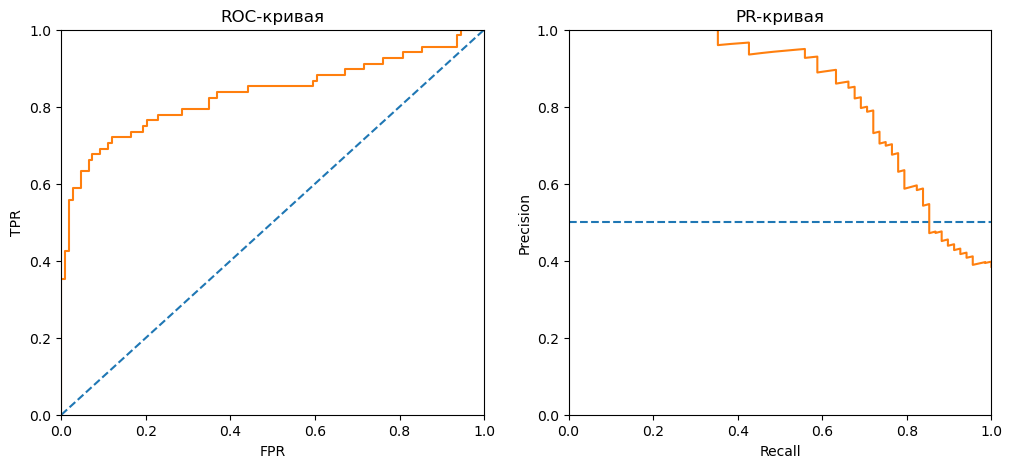

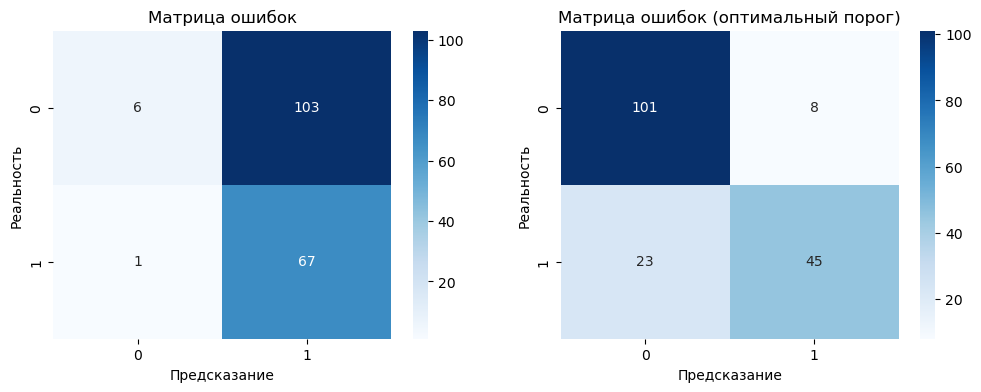

In [326]:
visualize(y_test, y_probs);

**Подбор оптимального порога относится к этапу принятия решения. Его следует проводить в финале исследования (ведь на практике может быть, к примеру, и несколько порогов с разными действиями).**

## Логистическая регрессия в sklearn

In [343]:
lr = LogisticRegression(random_state=177013, penalty=None)

In [344]:
lr.fit(X_train, y_train)

LogisticRegression(penalty=None, random_state=177013)

In [345]:
y_probs = lr.predict_proba(X_test)

In [346]:
y_probs[:5]

array([[0.07057604, 0.92942396],
       [0.0341505 , 0.9658495 ],
       [0.76477286, 0.23522714],
       [0.27431033, 0.72568967],
       [0.29584044, 0.70415956]])

ROC_AUC: 0.95, AP (PR_AUC): 0.94, наилучший F1: 0.89 с порогом 0.41 (accuracy 0.88)


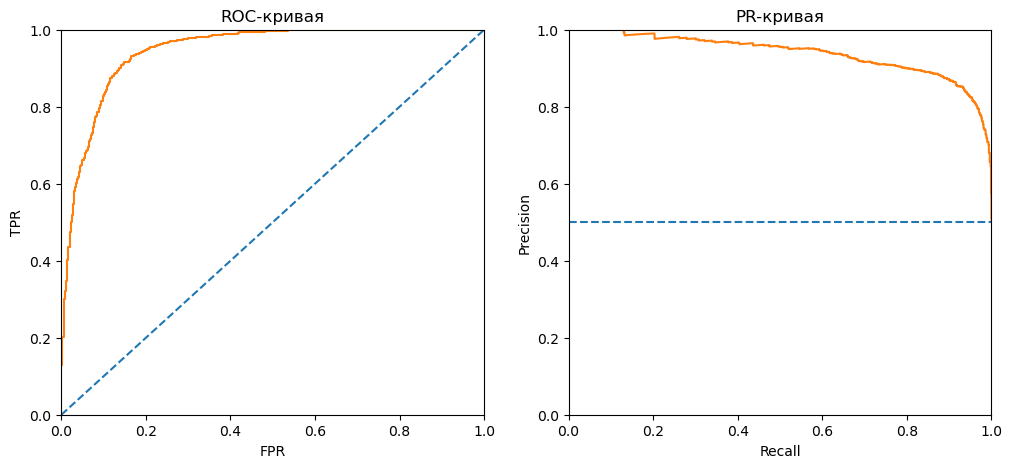

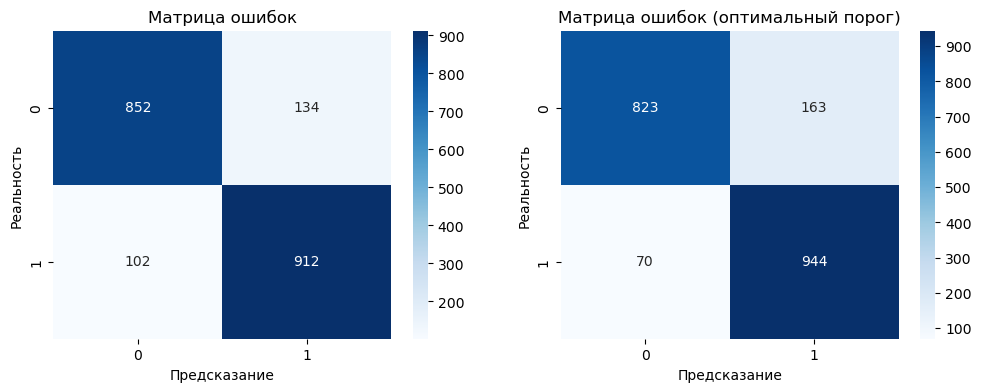

In [347]:
visualize(y_test, y_probs[:,1]);

In [348]:
lr.coef_

array([[ 0.02700999, -0.07037427,  0.43854924, -0.14235302,  0.42183452,
        -0.03739715, -0.37397433, -0.25371962,  0.50570366, -0.00426424,
        -0.54916194,  0.5973746 ,  0.72573509, -0.11551876, -0.0466099 ,
         0.2679047 ,  0.07407078, -0.00249167,  0.02181434, -0.00376539]])

In [261]:
lr.intercept_

array([-0.81519473])

## Градиентный спуск

In [336]:
scaler.fit(X_train)
X_train_b = scaler.transform(X_train)
X_train_b = np.hstack([X_train_b, np.ones((len(X_train), 1))])
X_test_b = scaler.transform(X_test)
X_test_b = np.hstack([X_test_b, np.ones((len(X_test), 1))])

In [ ]:
num_iterations = 100
learning_rate = 1e-4
nlltrain = []
nlltest = []
checkpoints = []

improved_weights = np.zeros(len(X_train.columns) + 1)

for _ in range(num_iterations):
    logits = X_train_b @ improved_weights
    
    probabilities = sigmoid(logits)
    
    error = probabilities - y_train
    nlltrain.append(log_loss(y_train, probabilities).mean())
    nlltest.append(log_loss(y_test, sigmoid(X_test_b @ improved_weights)).mean())
    
    gradient = X_train_b.T @ error
    
    improved_weights -= learning_rate * gradient
    checkpoints.append(improved_weights)

In [ ]:
improved_weights

In [ ]:
plt.plot(nlltrain);
plt.plot(nlltest);
plt.title('Функция потерь')
plt.xlabel('Итерация')
plt.ylabel('NLL');
plt.legend(['Обучающая выборка', 'Валидационная выборка']);

In [ ]:
y_logits = X_test_b @ improved_weights
y_probs = sigmoid(y_logits)

In [ ]:
accuracy_score(y_test, (y_probs > 0.5))

In [ ]:
np.argmin(msetest)

In [ ]:
final_weights = checkpoints[np.argmin(msetest)]

In [ ]:
y_logits = X_test_b @ final_weights
y_probs = sigmoid(y_logits)

In [ ]:
visualize(y_test, y_probs);

### Градиентный спуск в sklearn

In [349]:
sgd = SGDClassifier(random_state=177013, penalty=None, loss='log_loss', learning_rate='constant', eta0=1e-3)

In [350]:
sgd.fit(X_train_b, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [707, 8000]

In [ ]:
y_probs = sgd.predict_proba(X_test_b)
y_pred = sgd.predict(X_test_b)

In [ ]:
visualize(y_test, y_probs[:,1]);

## Регуляризация

In [ ]:
lr = LogisticRegression(random_state=177013, penalty='l2')

In [ ]:
lr.fit(X_train, y_train)

In [ ]:
y_probs = lr.predict_proba(X_test)

In [ ]:
y_probs[:5]

In [ ]:
visualize(y_test, y_probs[:,1]);

## Допущения логистической регрессии

По сравнению с обычной линейной регрессией, логистическая НЕ требует:

- гомоскедастичности;
- нормальности ошибок;
- поскольку результат проходит через логистическую функцию, линейная зависимость нужна для логитов, а не самого целевого признака, который бинарен.

# Домашнее задание

## Easy

С помощью sklearn можно генерировать простые датасеты для тестирования моделей:

In [380]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10000, n_features=20, n_informative=10, n_classes=2)
X_train, y_train = X[:8000], y[:8000]
X_test, y_test = X[8000:], y[8000:]

Воспользуйтесь примером из урока и постройте модель логистической регрессии. Проверьте метрику F1 с порогом по умолчанию.

In [381]:
# Ваш код ниже:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor, SGDClassifier, Ridge, Lasso
lr.fit(X_train, y_train)

AttributeError: 'Series' object has no attribute 'fit'

In [382]:
y_probs = lr.predict_proba(X_test)

AttributeError: 'Series' object has no attribute 'predict_proba'

In [383]:
y_probs[:5]

array([[0.0137308 , 0.9862692 ],
       [0.1964805 , 0.8035195 ],
       [0.09769659, 0.90230341],
       [0.15445989, 0.84554011],
       [0.5712446 , 0.4287554 ]])

C:\Users\Owner\AppData\Local\Temp\ipykernel_22504\4278985181.py:9: RuntimeWarning: invalid value encountered in divide
  f_scores = 2 * recall * precision / (recall + precision)


ROC_AUC: 0.51, AP (PR_AUC): 0.51, наилучший F1: nan с порогом 1.00 (accuracy 0.50)


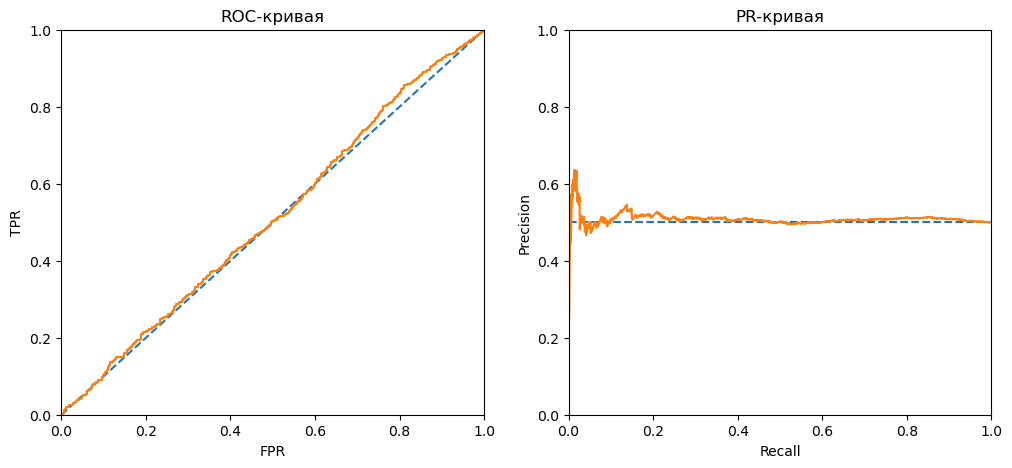

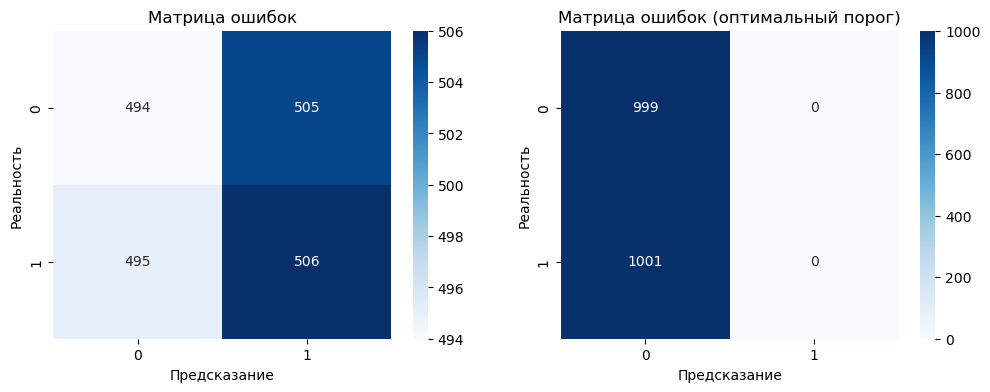

In [384]:
visualize(y_test, y_probs[:,1]);

In [385]:
lr.coef_

AttributeError: 'Series' object has no attribute 'coef_'

In [ ]:
lr.intercept_

## Normal

In [386]:
import pandas as pd
df = pd.read_csv('Churn_Modelling.csv')
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [387]:
import pandas as pd
import numpy as np

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', add_indicator=True).set_output(transform='pandas')
df = pd.read_csv('Churn_Modelling.csv').drop(['CustomerId', 'Surname', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography'], axis=1)
df['Gender'] = (df['Gender'] == 'male').astype('int')
df = imputer.fit_transform(df)
df.tail()

,RowNumber,CreditScore,Gender,Age,Tenure,Balance,EstimatedSalary,Exited
9995,9996.0,771.0,0.0,39.0,5.0,0.00,96270.64,0.0
9996,9997.0,516.0,0.0,35.0,10.0,57369.61,101699.77,0.0
9997,9998.0,709.0,0.0,36.0,7.0,0.00,42085.58,1.0
9998,9999.0,772.0,0.0,42.0,3.0,75075.31,92888.52,1.0
9999,10000.0,792.0,0.0,28.0,4.0,130142.79,38190.78,0.0


Вернитесь к датасету о клиентах банка. Подумайте, как преобразовать категории в числа (если не справитесь, можете их удалить, мы рассмотрим этот вопрос подробнее на следующем уроке).

Выделите обучающую и валидационную выборки.

Постройте модель логистической регрессии для предсказания признака `Exited`.

In [388]:
# Ваш код ниже:
lrr = df['Exited']
lrr

0       1.0
1       0.0
2       1.0
3       0.0
4       0.0
       ... 
9995    0.0
9996    0.0
9997    1.0
9998    1.0
9999    0.0
Name: Exited, Length: 10000, dtype: float64

In [389]:

lrr.fit(X_train, y_train)

AttributeError: 'Series' object has no attribute 'fit'

In [390]:
y_probs = lrr.predict_proba(X_test)
y_probs[:5]

AttributeError: 'Series' object has no attribute 'predict_proba'

C:\Users\Owner\AppData\Local\Temp\ipykernel_22504\4278985181.py:9: RuntimeWarning: invalid value encountered in divide
  f_scores = 2 * recall * precision / (recall + precision)


ROC_AUC: 0.51, AP (PR_AUC): 0.51, наилучший F1: nan с порогом 1.00 (accuracy 0.50)


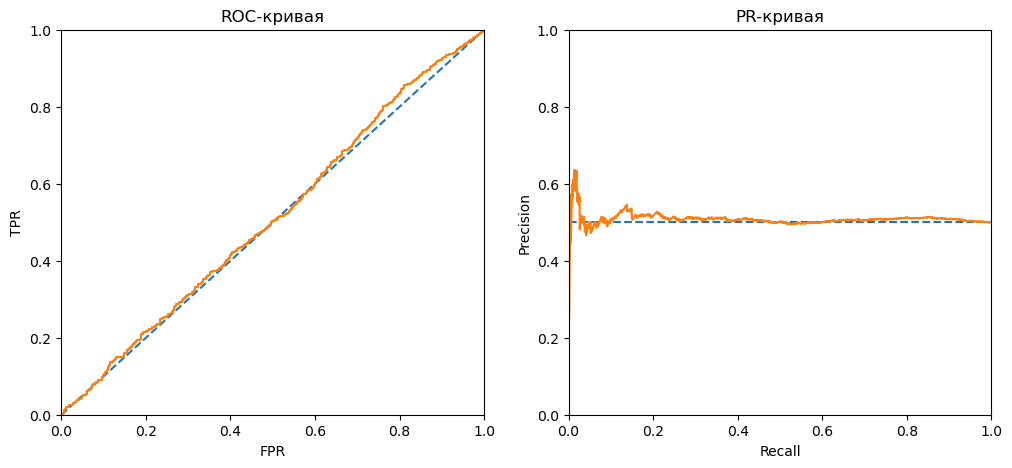

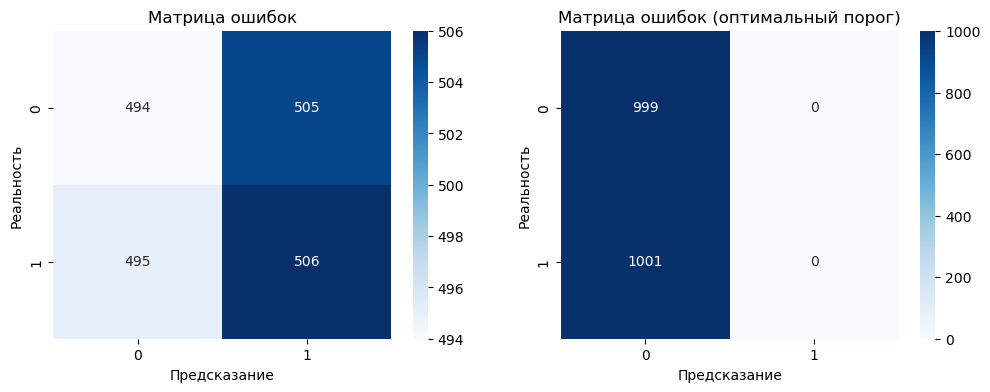

In [391]:
visualize(y_test, y_probs[:,1]);

In [392]:
lr.coef_

AttributeError: 'Series' object has no attribute 'coef_'

In [393]:
lrr.intercept_

AttributeError: 'Series' object has no attribute 'intercept_'

Проверьте метрику F1 с порогом по умолчанию. Попробуйте найти хороший порог классификации с помощью PR-кривой.

In [204]:
# Ваш код ниже:


Напишите краткий вывод. Хорошо ли работает модель? Если нет, то как вы думаете, почему?

Вывод: 

## Hard

In [236]:
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=10000, n_features=20, n_informative=10)
X_train, y_train = X[:8000], y[:8000]
X_test, y_test = X[8000:], y[8000:]

1. Постройте модель линейной регрессии. Оцените метрику на тестовой выборке.

In [231]:
# Ваш код ниже:


2. Сгенерируйте случайную матрицу 20х20 (можно воспользоваться `sklearn.datasets.make_spd_matrix()`). Проверьте ее на невырожденность (`np.linalg.det()` не должен равняться 0).

    Умножьте X_train и X_test на эту матрицу. Постройте модель линейной регрессии по этим преобразованным данным.

    Проверьте метрику. Что вы наблюдаете?

In [231]:
# Ваш код ниже:


С помощью линейной алгебры и формул линейной регрессии объясните, почему так происходит.